Bibliotheken importieren

In [1]:
import os
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2

TEMPORÄR: PIL/Pillow konfigurieren, um beschädigte Bilder ignorieren

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Datensatz laden

In [3]:
# pfad definieren
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

def load_images(ordner, img_groesse=(32, 32)):
    bilder = []
    labels = []

    for klasse in os.listdir(ordner):
        klasse_pfad = os.path.join(ordner, klasse)
        if not os.path.isdir(klasse_pfad):
            continue

        print(f"Lade {klasse} Bilder aus {klasse_pfad}")
        for bild_datei in os.listdir(klasse_pfad):
            bild_pfad = os.path.join(klasse_pfad, bild_datei)
            bild = cv2.imread(bild_pfad)
            if bild is None:
                continue
            bild = cv2.resize(bild, img_groesse)
            bild = bild / 255.0
            bilder.append(bild)
            labels.append(1 if klasse == 'wildfire' else 0)

    return np.array(bilder), np.array(labels)

X_train, y_train = load_images(train_dir)
X_val, y_val = load_images(val_dir)
X_test, y_test = load_images(test_dir)

print(f"Training: {len(X_train)} Bilder")
print(f"Validierung: {len(X_val)} Bilder")
print(f"Test: {len(X_test)} Bilder")


Lade nowildfire Bilder aus dataset/train/nowildfire


Premature end of JPEG file


Lade wildfire Bilder aus dataset/train/wildfire
Lade nowildfire Bilder aus dataset/valid/nowildfire
Lade wildfire Bilder aus dataset/valid/wildfire
Lade nowildfire Bilder aus dataset/test/nowildfire
Lade wildfire Bilder aus dataset/test/wildfire


Premature end of JPEG file


Training: 30250 Bilder
Validierung: 6300 Bilder
Test: 6300 Bilder


In [4]:
# konvertiere labels zu kategorisch (one-hot encoding)
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# mische daten
X_train, y_train_cat = shuffle(X_train, y_train_cat)

Datenvisualisierung

In [43]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32
steps_per_epoch = len(X_train) // batch_size
# erstelle trainingsdatensatz
train_generator = train_datagen.flow(
    X_train, y_train_cat,
    batch_size=batch_size,
    shuffle=True
)

Training: 30250 Bilder
Validierung: 6300 Bilder
Test: 6300 Bilder


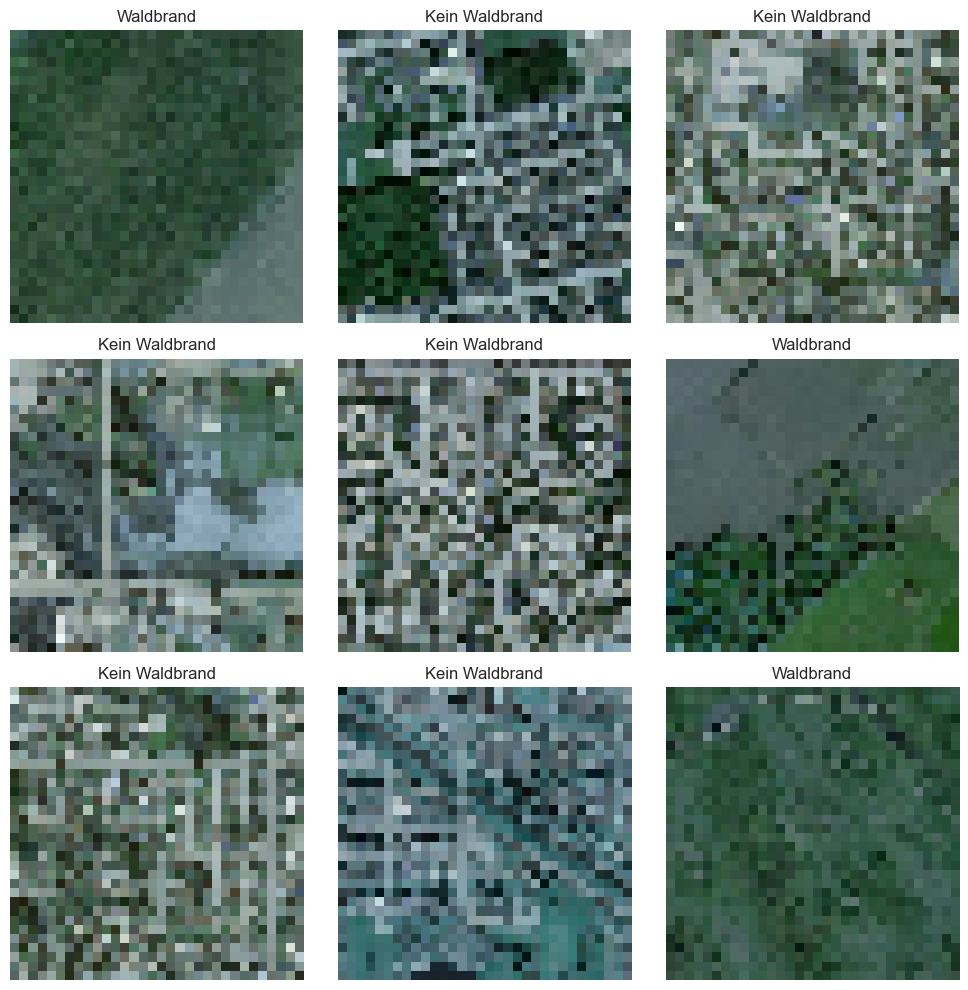

In [44]:
print(f"Training: {len(X_train)} Bilder")
print(f"Validierung: {len(X_val)} Bilder")
print(f"Test: {len(X_test)} Bilder")

def zeige_batch(bilder, labels, anzahl=9):
    plt.figure(figsize=(10, 10))
    for i in range(min(anzahl, len(bilder))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(bilder[i])
        if isinstance(labels[i], np.ndarray) and len(labels[i]) > 1:
            label = np.argmax(labels[i])
        else:
            label = labels[i]

        plt.title('Waldbrand' if label == 1 else 'Kein Waldbrand')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

zeige_batch(X_train, y_train_cat)
image_batch, label_batch = next(train_generator)

CNN erstellen

In [28]:
img_height, img_width = 32, 32
def create_custom_cnn():
    model = models.Sequential([
        layers.Input(shape=(img_height, img_width, 3)),

        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),

        layers.Flatten(),

        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        weighted_metrics=['accuracy']
    )

    return model

custom_model = create_custom_cnn()
custom_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,418 (4.08 MB)

 Trainable params: 1,068,290 (4.08 MB)

 Non-trainable params: 128 (512.00 B)

Modelltraining

In [34]:
epochs = 15

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)
steps_per_epoch = len(X_train) // batch_size
class_weights = {0: 1.0, 1: 4.0}
custom_history = custom_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.9279 - loss: 0.2782 - weighted_accuracy: 0.9605 - val_accuracy: 0.9081 - val_loss: 0.3009 - val_weighted_accuracy: 0.9081 - learning_rate: 5.0000e-04
Epoch 2/15
  1/945 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9062 - loss: 0.8111 - weighted_accuracy: 0.9277

/Users/hito/miniconda3/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9062 - loss: 0.8111 - weighted_accuracy: 0.9277 - val_accuracy: 0.9071 - val_loss: 0.3020 - val_weighted_accuracy: 0.9071 - learning_rate: 5.0000e-04
Epoch 3/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.9357 - loss: 0.2467 - weighted_accuracy: 0.9669 - val_accuracy: 0.9195 - val_loss: 0.2494 - val_weighted_accuracy: 0.9195 - learning_rate: 5.0000e-04
Epoch 4/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.3509 - weighted_accuracy: 0.9490 - val_accuracy: 0.9214 - val_loss: 0.2428 - val_weighted_accuracy: 0.9214 - learning_rate: 5.0000e-04
Epoch 5/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.9368 - loss: 0.2456 - weighted_accuracy: 0.9667 - val_accuracy: 0.8944 - val_loss: 0.5911 - val_weighted_accuracy: 0.8944 - learning_rate: 5.0000e-04
Epoch 6/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0401 - weighted_accuracy: 1.0000 - val_accuracy: 0.8902 - val_

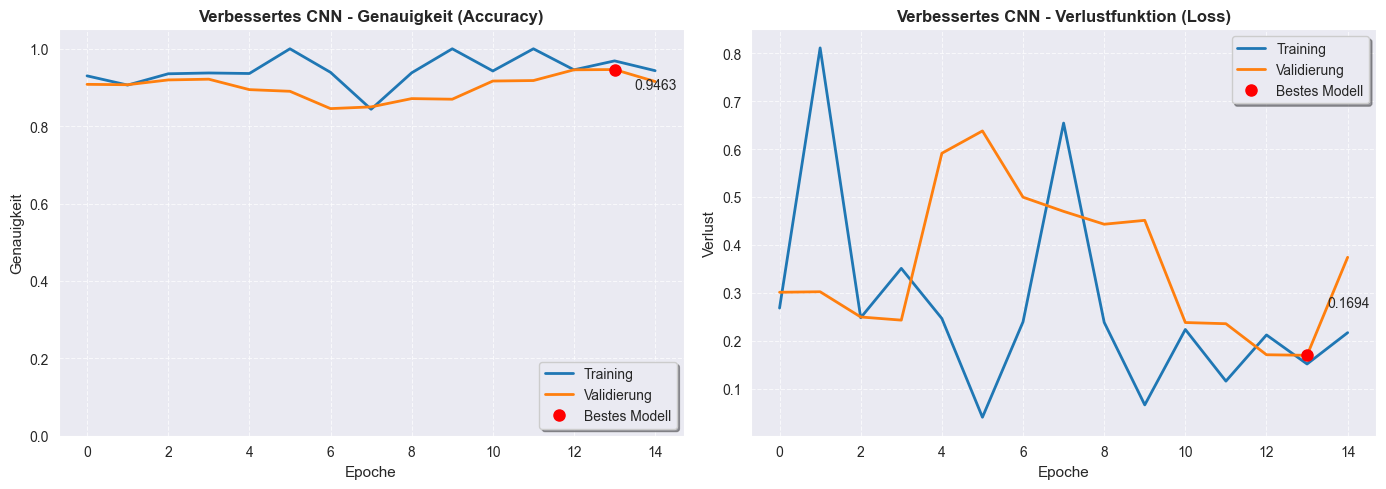

Modell-Metriken: ['loss', 'compile_metrics']
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9397 - loss: 0.2310 - weighted_accuracy: 0.9397
loss: 0.1774
compile_metrics: 0.9473
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
CM in der Funktion: [[2650  170]
 [ 162 3318]]


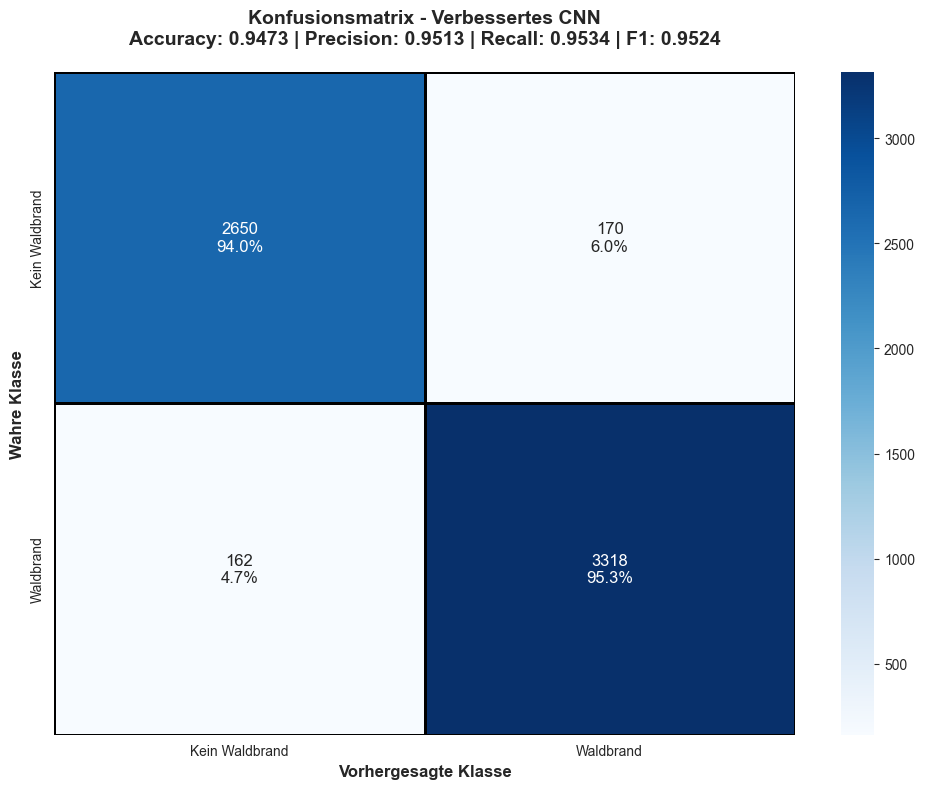


Klassifikationsmetriken:
Accuracy: 0.9473
Precision: 0.9513
Recall: 0.9534
F1-Score: 0.9524


In [37]:
def plot_history(history, title, figsize=(14, 5)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], linewidth=2)
    plt.plot(history.history['val_accuracy'], linewidth=2)

    best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_val_acc_epoch]
    plt.plot(best_val_acc_epoch, best_val_acc, 'ro', markersize=8)
    plt.annotate(f'{best_val_acc:.4f}',
                 xy=(best_val_acc_epoch, best_val_acc),
                 xytext=(best_val_acc_epoch + 0.5, best_val_acc - 0.05),
                 fontsize=10)

    plt.title(f'{title} - Genauigkeit (Accuracy)', fontsize=12, fontweight='bold')
    plt.ylabel('Genauigkeit', fontsize=11)
    plt.xlabel('Epoche', fontsize=11)
    plt.ylim([0, 1.05])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(['Training', 'Validierung', 'Bestes Modell'], loc='lower right', frameon=True, fancybox=True, shadow=True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], linewidth=2)
    plt.plot(history.history['val_loss'], linewidth=2)

    best_val_loss_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = history.history['val_loss'][best_val_loss_epoch]
    plt.plot(best_val_loss_epoch, best_val_loss, 'ro', markersize=8)
    plt.annotate(f'{best_val_loss:.4f}',
                 xy=(best_val_loss_epoch, best_val_loss),
                 xytext=(best_val_loss_epoch + 0.5, best_val_loss + 0.1),
                 fontsize=10)

    plt.title(f'{title} - Verlustfunktion (Loss)', fontsize=12, fontweight='bold')
    plt.ylabel('Verlust', fontsize=11)
    plt.xlabel('Epoche', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(['Training', 'Validierung', 'Bestes Modell'], loc='upper right', frameon=True, fancybox=True, shadow=True)

    if 'lr' in history.history:
        plt.figure(figsize=(7, 3))
        plt.plot(history.history['lr'], linewidth=2)
        plt.title('Learning Rate Verlauf', fontsize=12, fontweight='bold')
        plt.ylabel('Learning Rate', fontsize=11)
        plt.xlabel('Epoche', fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.yscale('log')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test_cat):
    try:
        print("Modell-Metriken:", model.metrics_names)
        evaluation_results = model.evaluate(X_test, y_test_cat, verbose=1)

        results_dict = {}
        for i, metric_name in enumerate(model.metrics_names):
            results_dict[metric_name] = evaluation_results[i]
            print(f"{metric_name}: {evaluation_results[i]:.4f}")

        return results_dict

    except Exception as e:
        print(f"Fehler bei der Modellauswertung: {e}")
        loss = model.evaluate(X_test, y_test_cat, verbose=0)
        print(f"Loss: {loss:.4f}")
        return {'loss': loss}

def plot_confusion_matrix(y_true, y_pred, title="Konfusionsmatrix", figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred)
    print("CM in der Funktion:", cm)

    if cm.shape != (2, 2):
        print(f"WARNUNG: Konfusionsmatrix hat unerwartete Dimensionen: {cm.shape}")
        if cm.shape[0] > 2 or cm.shape[1] > 2:
            cm_new = np.zeros((2, 2))
            cm_new[0, 0] = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
            cm_new[0, 1] = cm[0, 1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
            cm_new[1, 0] = cm[1, 0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
            cm_new[1, 1] = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
            cm = cm_new
            print("Korrigierte Matrix:", cm)

    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100

    annot = np.zeros_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n{cm_perc[i, j]:.1f}%"

    plt.figure(figsize=figsize)

    ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', cbar=True,
                    linewidths=1, linecolor='black', annot_kws={"size": 12})

    plt.title(f'{title}\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Wahre Klasse', fontsize=12, fontweight='bold')
    plt.xlabel('Vorhergesagte Klasse', fontsize=12, fontweight='bold')

    ax.xaxis.set_ticklabels(['Kein Waldbrand', 'Waldbrand'], fontsize=10)
    ax.yaxis.set_ticklabels(['Kein Waldbrand', 'Waldbrand'], fontsize=10)

    plt.tight_layout()
    plt.show()

    print("\nKlassifikationsmetriken:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

def vorhersage_einzelbild(model, bild_pfad, img_width=32, img_height=32, threshold=0.5):
    try:
        bild = cv2.imread(bild_pfad)
        if bild is None:
            print(f"Fehler: Bild konnte nicht geladen werden - {bild_pfad}")
            return None, None

        bild_anzeige = cv2.cvtColor(bild, cv2.COLOR_BGR2RGB)
        bild = cv2.resize(bild, (img_width, img_height))
        bild = bild / 255.0
        bild = np.expand_dims(bild, axis=0)

        vorhersage = model.predict(bild, verbose=0)
        klasse_wahrscheinlichkeit = vorhersage[0][1]

        klasse_name = 'Waldbrand' if klasse_wahrscheinlichkeit > threshold else 'Kein Waldbrand'

        plt.figure(figsize=(10, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(bild_anzeige)
        plt.title(f'Vorhersage: {klasse_name}', fontsize=12, fontweight='bold')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        waldbrand_conf = vorhersage[0][1] * 100
        kein_waldbrand_conf = vorhersage[0][0] * 100

        bars = plt.barh(['Waldbrand', 'Kein Waldbrand'],
                        [waldbrand_conf, kein_waldbrand_conf],
                        color=['crimson', 'forestgreen'])

        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%', ha='left', va='center', fontweight='bold')

        plt.xlim([0, 105])
        plt.title('Konfidenz (%)', fontsize=12, fontweight='bold')
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        plt.gca().set_facecolor('#ffeeee' if klasse_name == 'Waldbrand' else '#eeffee')

        plt.axvline(x=threshold*100, color='blue', linestyle='--', linewidth=2)
        plt.text(threshold*100 + 1, 0.5, f'Schwellenwert ({threshold*100:.0f}%)',
                 ha='left', va='center', color='blue', fontweight='bold')

        plt.tight_layout()
        plt.show()

        return klasse_name, klasse_wahrscheinlichkeit

    except Exception as e:
        print(f"Fehler bei der Bildvorhersage: {e}")
        return None, None

plot_history(custom_history, 'Verbessertes CNN')

eval_results = evaluate_model(custom_model, X_test, y_test_cat)

predictions = custom_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test_cat, axis=1)
plot_confusion_matrix(y_true, y_pred, title="Konfusionsmatrix - Verbessertes CNN")


Waldbrand test

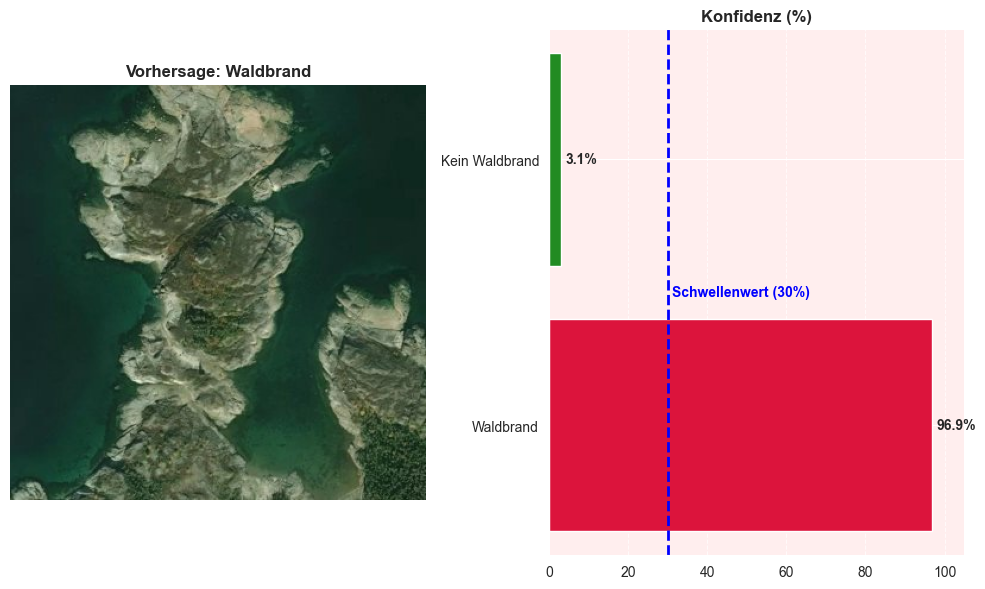

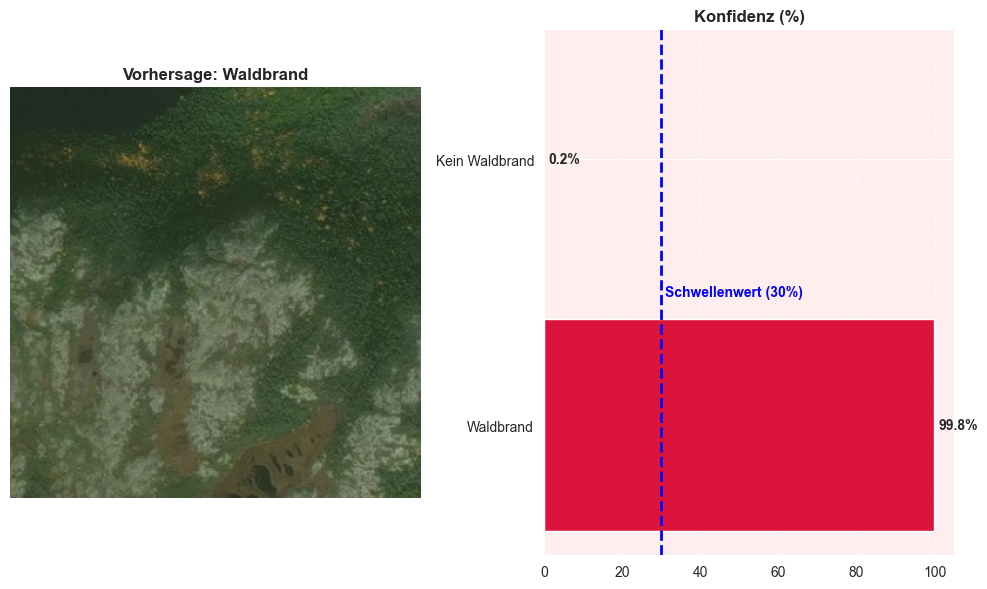

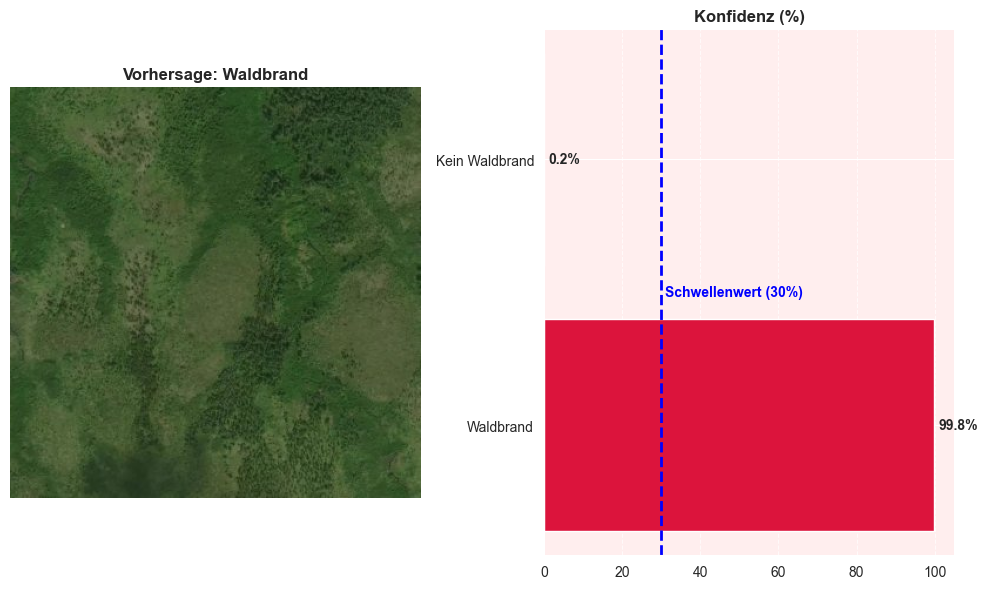

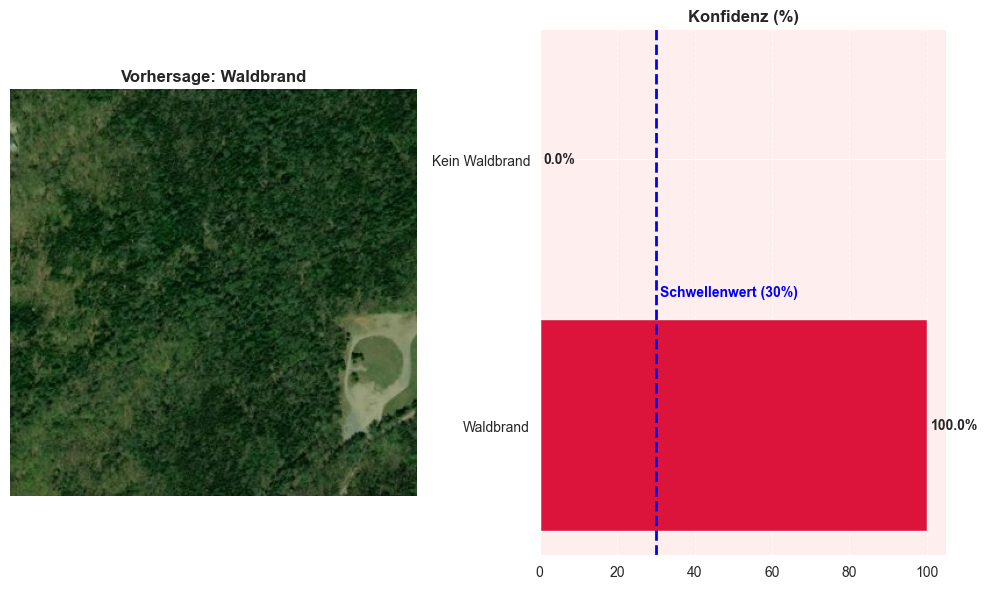

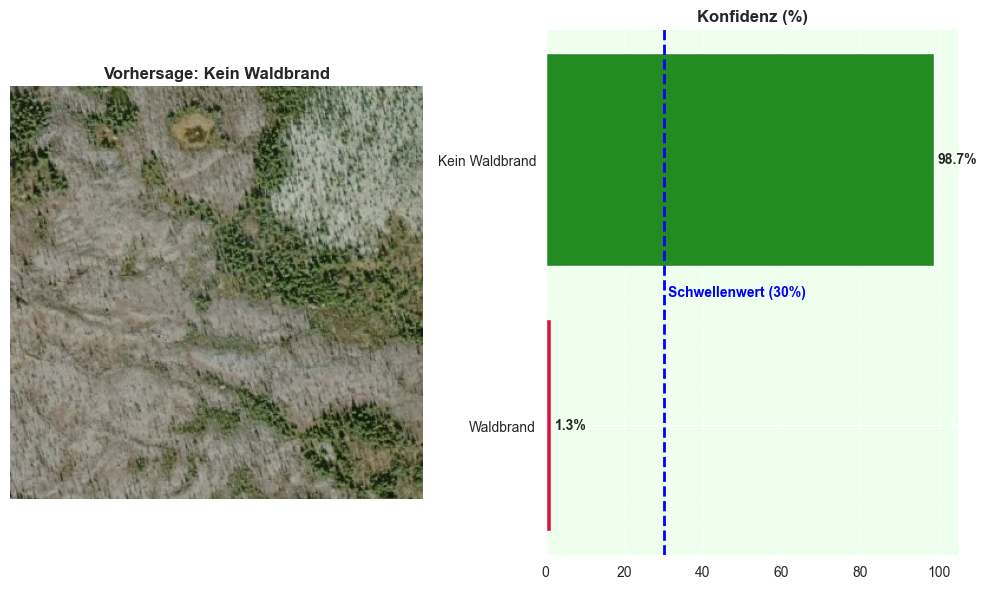

('Kein Waldbrand', np.float32(0.012936745))

In [38]:
test_bild_pfad = "dataset/valid/wildfire/-67.01362,49.83423.jpg"
vorhersage_einzelbild(custom_model, test_bild_pfad, threshold=0.3)
test_bild_pfad = "dataset/train/wildfire/-60.9444,50.3885.jpg"
vorhersage_einzelbild(custom_model, test_bild_pfad, threshold=0.3)
test_bild_pfad = "dataset/test/wildfire/-78.94987,51.10492.jpg"
vorhersage_einzelbild(custom_model, test_bild_pfad, threshold=0.3)
test_bild_pfad = "dataset/train/wildfire/-71.30437,46.91247.jpg"
vorhersage_einzelbild(custom_model, test_bild_pfad, threshold=0.3)
test_bild_pfad = "dataset/valid/wildfire/-59.0017,51.9556.jpg"
vorhersage_einzelbild(custom_model, test_bild_pfad, threshold=0.3)

Kein Waldbrand test

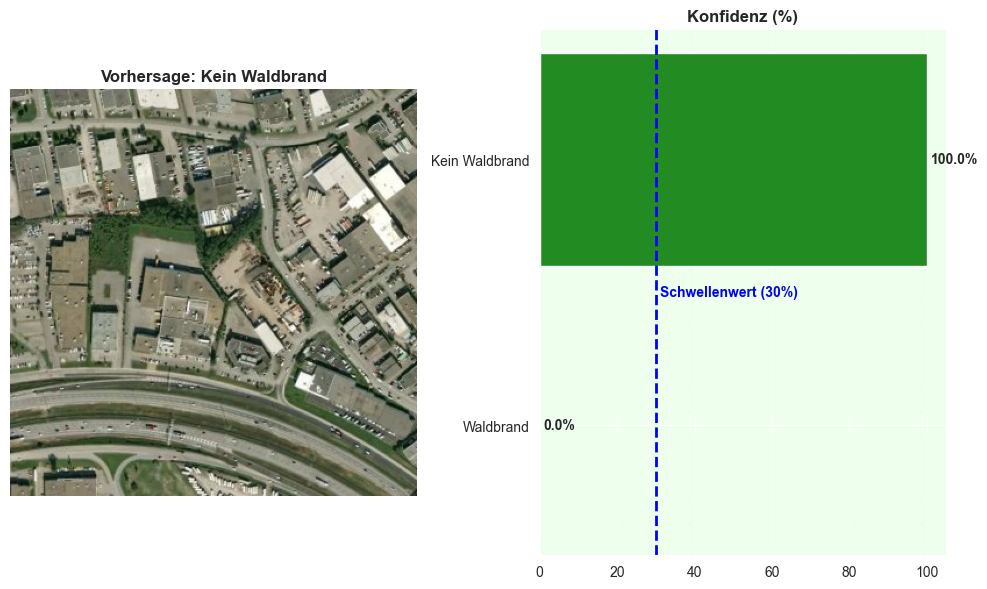

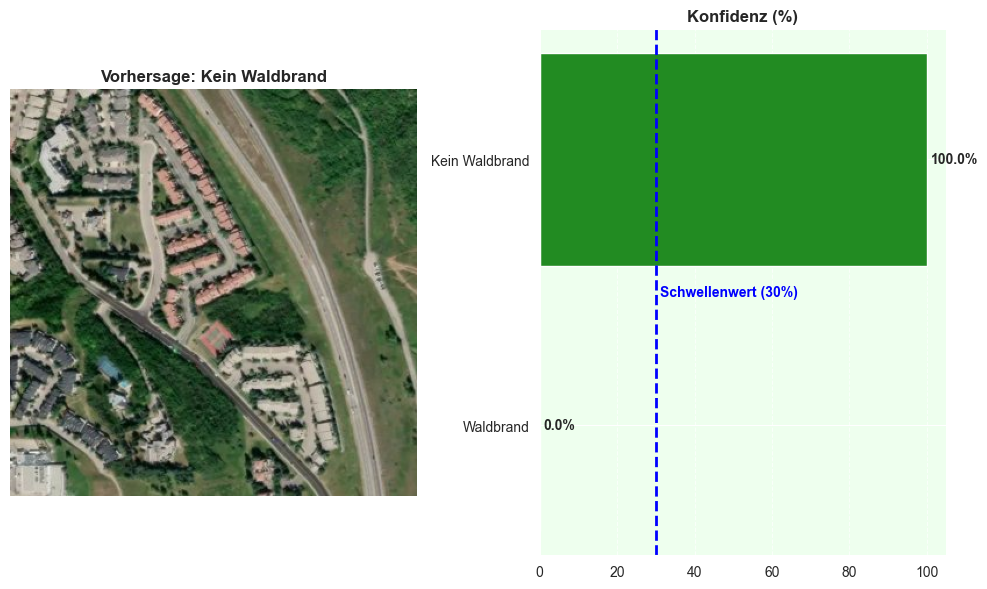

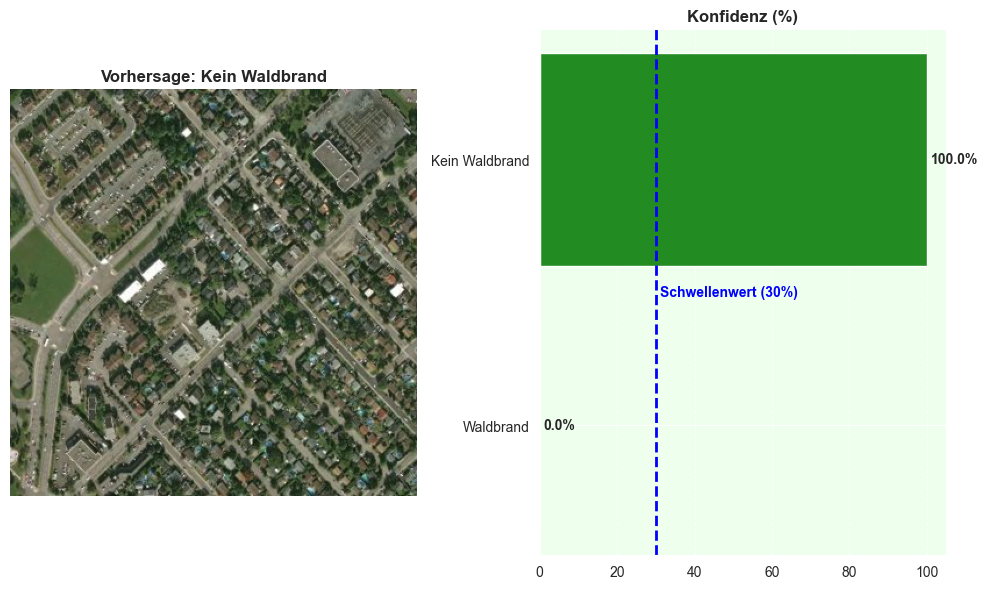

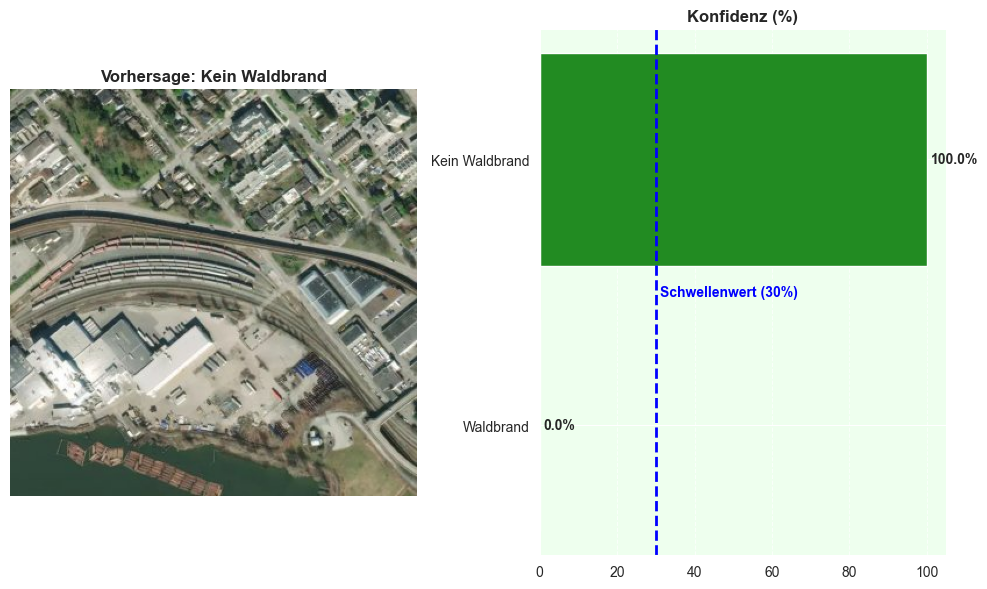

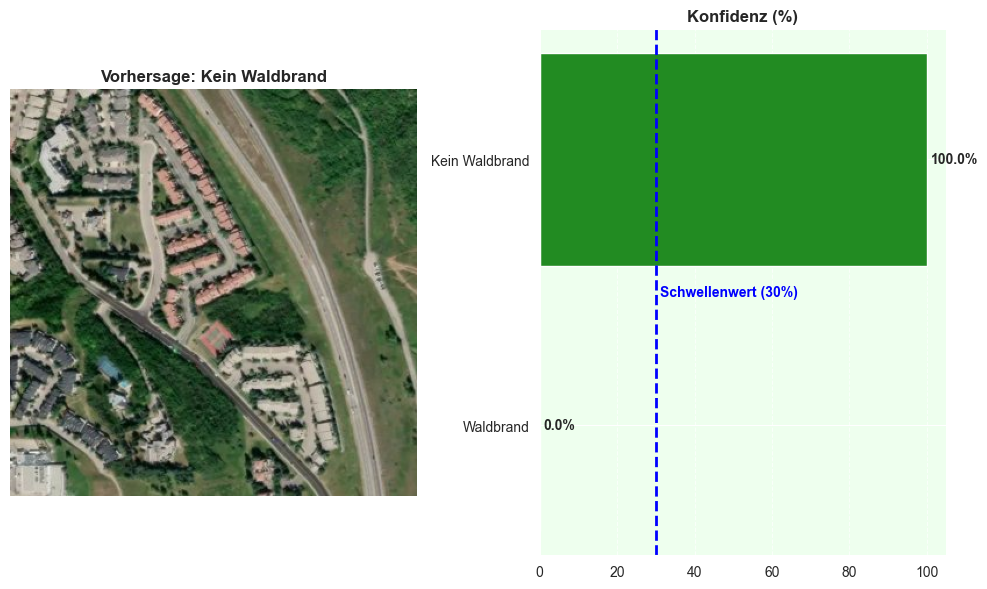

('Kein Waldbrand', np.float32(6.969644e-07))

In [39]:
test_bild_pfad = "dataset/valid/nowildfire/-73.7592,45.582753.jpg"
vorhersage_einzelbild(custom_model, test_bild_pfad, threshold=0.3)
test_bild_pfad = "dataset/valid/nowildfire/-114.167338,51.061201.jpg"
vorhersage_einzelbild(custom_model, test_bild_pfad, threshold=0.3)
test_bild_pfad = "dataset/train/nowildfire/-73.4525,45.545352.jpg"
vorhersage_einzelbild(custom_model, test_bild_pfad, threshold=0.3)
test_bild_pfad = "dataset/test/nowildfire/-122.93133,49.202953.jpg"
vorhersage_einzelbild(custom_model, test_bild_pfad, threshold=0.3)
test_bild_pfad = "dataset/valid/nowildfire/-114.167338,51.061201.jpg"
vorhersage_einzelbild(custom_model, test_bild_pfad, threshold=0.3)

In [46]:
custom_model.save("waldbrand_erkennungsmodell.keras")